In [1]:
#from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy.interpolate import splrep, splev
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

In [2]:
def smape(satellite_predicted_values, satellite_true_values):
    # the division, addition and subtraction are pointwise
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values)/
                (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))


def drop_close(t, x, eps=10**9):
    '''
    t = time array, x = data array, eps is in nanoseconds
    Returns entries in t,x with corresponding consecutive times > eps
    
    '''
    t = np.array(t) #if not already np array, convert
    x = np.array(x) #if t or x are pandas Series, will have dimension mismatch
    far = np.concatenate([(t[1:] - t[:-1]) > eps, [True]])
    return t[far], x[far]


def resample(t, x, step=10 * 10**9, t_new=None, return_t=False):
    '''
    t: time array (or series); 
    x: data array (or series); 
    t_new: new time scale from start to end of t with step size step;
    step: = 10 seconds by default; 
    return_t: by default, do not return resampled times
    
    resample time series or array by 10 (default) sec intervals and 
    return new time series (if t_new=True) and spline approximation series for data
    
    
    '''
    t, x = drop_close(t, x)
    if t_new is None:
        t_new = np.arange(t[0], t[-1], step)
    try:
        spl = splrep(t, x)
        x_new = splev(t_new, spl)
    except:
        raise ValueError(f'interpolation error, x length = {len(x)}, \
        t_new length = {len(t_new)}')

    return (t_new, x_new) if return_t else x_new


def get_peaks(array):
    '''
    returns index of "sharp" peaks, excluding first and last values of array
    
    index of "smooth peaks", e.g. 1 2 3 9 9 3 2 1, is not returned
    '''
    return np.where((array[1:-1] > array[2:]) & (array[1:-1] > array[:-2]))[0] + 1


def get_satellite_data(data, sat_id):
    '''
    returns all data for particular satellite by id
    '''
    return data[data['sat_id'] == sat_id].reset_index(drop=True)


def remove_time_jumps(satellite_data, features_list=('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                      suffix='_jumps_removed',time_threshold = 0.00003):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    '''
    satellite_data['t'] = ((pd.to_datetime(satellite_data['epoch']) - pd.to_datetime(satellite_data['epoch'])[0]) /
                           np.timedelta64(1, 'D')).astype(float)
    satellite_data['dt'] = satellite_data['t'].diff()
    # the most frequent time interval
    t_standard = satellite_data['dt'].value_counts().index[0]

    # time steps used for simulations
    satellite_data['t_sim'] = satellite_data.index.values * t_standard

    n = satellite_data.shape[0]
    corrected_features = []
    for feature_name in features_list:
        corrected_feature = [0] * n
        corrected_feature[0] = satellite_data[feature_name][0]

        feature = satellite_data[feature_name]

        for j in range(1, n - 1):
            if satellite_data.t[j] < satellite_data.t_sim[j] - time_threshold:
                # approximate by the left side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] < satellite_data.t_sim[j - step] - time_threshold:
                    step += 1
                #             print(step)
                corrected_feature[j] = feature[j - step] - (satellite_data.t_sim[j - step] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j - step] - satellite_data.t_sim[j - step - 1]) * (
                                              feature[j - step] - feature[j - step - 1])
            elif satellite_data.t[j] > satellite_data.t_sim[j] + time_threshold:
                # approximate by the right side
    
                # look for the interval
                step = 0
                while satellite_data.t[j] > satellite_data.t_sim[j + step] + time_threshold:
                    step += 1
    
                corrected_feature[j] = feature[j + step + 1] - (satellite_data.t_sim[j + step + 1] - satellite_data.t[j]) / (
                            satellite_data.t_sim[j + step + 1] - satellite_data.t_sim[j + step]) * (
                                              feature[j + step + 1] - feature[j + step])
            else:
                corrected_feature[j] = feature[j]
    
        corrected_feature[n - 1] = feature[n - 1] + corrected_feature[n - 2] - feature[n - 2]
        corrected_features.append(corrected_feature)
    return pd.DataFrame(corrected_features, index=[f + suffix for f in features_list]).T

In [3]:
def insert_previous_and_shift(df,col_name,ind):
    '''
    input a data frame (df), column name (col_name), and index (ind)
    insert previous value of df[col_name] at index and shift the rest 
    of df[col_name] from ind by +1;
    This is used for remove_time_jumps_fast
    '''
    shifted_series = df[col_name].shift(1)
    df[col_name].iloc[ind] = df[col_name].iloc[ind-1]
    df[col_name].iloc[ind+1:] = shifted_series.iloc[ind+1:]
    return df

In [4]:
def remove_time_jumps_fast(data, features_list=
                           ('x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'),
                           threshold = 0.000001):
    #time_threshold 0.00003 sufficient for test and train
    #time_threshold 0.00002 will throw errors
    '''
    removes time jumps in the simulation for a single satellite
    for train and test data, sufficient to set time_threshold at default
    s_data = satellite data
    the features are replaced by the correction
    note that threshold here is not the same as in remove_time_jumps
    '''
    data['t'] = ((pd.to_datetime(data['epoch']) - pd.to_datetime(data['epoch'])[0]) /
                               np.timedelta64(1, 'D')).astype(float)
    data['dt'] = data['t'].diff(1)

    index_for_correction = data[data['dt'] < threshold].index 
    #print(index_for_correction)
    if list(index_for_correction): #if non empty
        for feature in features_list:
            for i in index_for_correction:
                data = insert_previous_and_shift(data,feature,i)
    return data

In [5]:
#!jupyter nbconvert --to script utils_edit_mb.ipynb

In [6]:
s_data = pd.read_csv('./data/train.csv', index_col= 'id')

In [7]:
#s_data_test = pd.read_csv('/Users/m/IDAO2020/Track 1/test.csv', index_col= 'id')

In [8]:
data = get_satellite_data(s_data, 0)
data.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [9]:
data.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
953,2014-01-31T20:27:33.474,0,17337.596150,-3224.996803,40025.071742,-0.055615,2.650511,-0.222561,15425.677762,12387.078210,35145.771830,-0.582846,2.494074,-1.433946
954,2014-01-31T21:14:16.474,0,16849.590836,4217.959953,38636.167298,-0.295282,2.642711,-0.774030,13419.744899,19007.658296,30280.477329,-0.849621,2.201501,-2.039018
955,2014-01-31T22:00:59.475,0,15667.981809,11481.446566,35656.909015,-0.550136,2.518368,-1.356292,10662.661170,24548.177490,23720.743216,-1.116261,1.715430,-2.636835
956,2014-01-31T22:47:42.475,0,13754.838284,18199.705814,31013.052037,-0.816256,2.247835,-1.959266,7182.757625,28395.590633,15553.985280,-1.360095,0.984696,-3.173250
957,2014-01-31T23:34:25.476,0,11090.021201,23908.338391,24674.831301,-1.084189,1.790199,-2.559726,3099.591832,29798.085757,6083.094021,-1.536935,-0.033515,-3.544768


In [10]:
data_rtjf = remove_time_jumps_fast(data)
data_rtjf.head()

c:\users\tatiana\anaconda3\envs\idao\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t,dt
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,0.000000,NaN
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,0.032442,0.032442
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,0.064884,0.032442
3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,0.097326,0.032442
4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,0.129769,0.032442


In [11]:
data_rtjf.tail()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,t,dt
953,2014-01-31T20:27:33.474,0,17337.596150,-3224.996803,40025.071742,-0.055615,2.650511,-0.222561,17269.627379,-2275.948161,39925.025372,-0.084964,2.656988,-0.290960,30.852471,0.032442
954,2014-01-31T21:14:16.474,0,16849.590836,4217.959953,38636.167298,-0.295282,2.642711,-0.774030,16696.850918,5166.718053,38337.176299,-0.326478,2.635548,-0.847468,30.884913,0.032442
955,2014-01-31T22:00:59.475,0,15667.981809,11481.446566,35656.909015,-0.550136,2.518368,-1.356292,15425.677762,12387.078210,35145.771830,-0.582846,2.494074,-1.433946,30.917355,0.032442
956,2014-01-31T22:47:42.475,0,13754.838284,18199.705814,31013.052037,-0.816256,2.247835,-1.959266,13419.744899,19007.658296,30280.477329,-0.849621,2.201501,-2.039018,30.949797,0.032442
957,2014-01-31T23:34:25.476,0,11090.021201,23908.338391,24674.831301,-1.084189,1.790199,-2.559726,10662.661170,24548.177490,23720.743216,-1.116261,1.715430,-2.636835,30.982239,0.032442


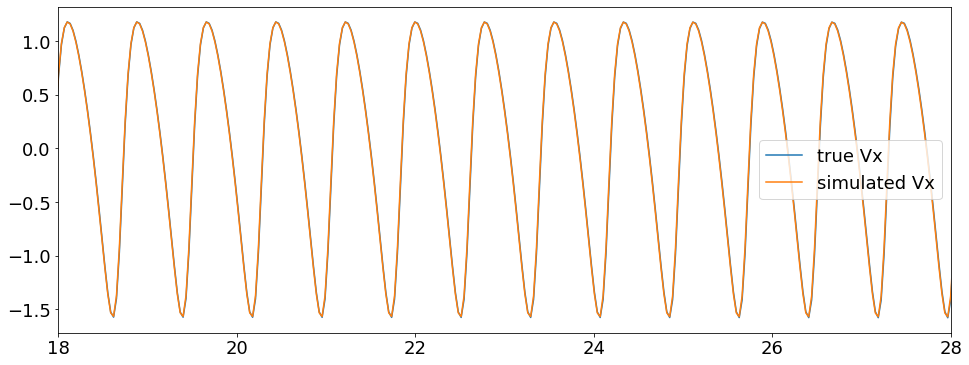

In [12]:
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vx'], label = 'true Vx');
plt.plot(data['t'],data['Vx_sim'], label = 'simulated Vx');

plt.xlim([18,28]);
plt.legend();

In [13]:
#run for all satellites and print sat id if error occurs
from tqdm import tqdm
for i in tqdm(range(600)):
    try:
        remove_time_jumps_fast(get_satellite_data(s_data, i))
    except:
        print(i)

100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 60.40it/s]


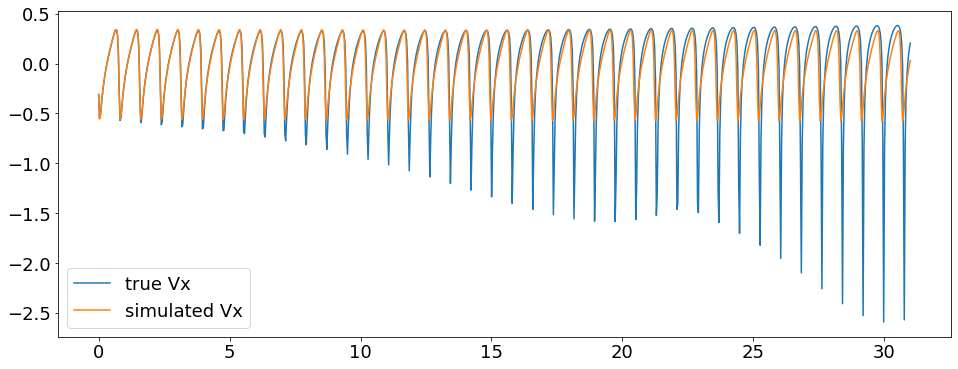

In [75]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 530))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vz'], label = 'true Vx');
plt.plot(data['t'],data['Vz_sim'], label = 'simulated Vx');

# plt.xlim([0,10])
#plt.xlim([10,20])
# plt.xlim([22,24])
plt.legend();

In [15]:
data.shape

(950, 16)

## Explore time scale stretch for simulations

In [16]:
true_feats = ['x','y','z','Vx','Vy','Vz']
sim_feats = [f + '_sim' for f in true_feats]
stretched_feats = [f+'_stretch' for f in true_feats]

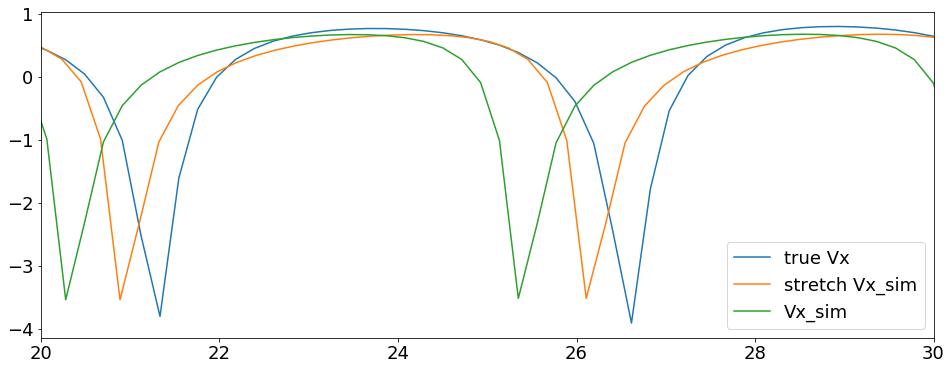

In [17]:
data = remove_time_jumps_fast(get_satellite_data(s_data, 391))
plt.figure(figsize=(16, 6))
plt.plot(data['t'],data['Vz'], label = 'true Vx');
plt.plot(1.03*data['t'],data['Vz_sim'], label = 'stretch Vx_sim');
plt.plot(data['t'],data['Vz_sim'], label = 'Vx_sim');

plt.xlim([0,10])
#plt.xlim([10,20])
plt.xlim([20,30])
plt.legend();

In [18]:
smape(data[true_feats].to_numpy(),data[sim_feats].to_numpy())

0.35520692028371315

In [21]:
smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())

KeyError: "None of [Index(['x_stretch', 'y_stretch', 'z_stretch', 'Vx_stretch', 'Vy_stretch',\n       'Vz_stretch'],\n      dtype='object')] are in the [columns]"

In [20]:
def stretch_simulated_feats(data, stretch,true_feats = ['x','y','z','Vx','Vy','Vz'],
                           suffix="_stretch"):
    '''
    stretch time scale for simulation to better match true data,
    for a single sattelite;
    use predetermined stretch coefficient (depends on the satellite)
    
    '''
    for feature in true_feats:
        spl = splrep(stretch*data['t'],data[feature+'_sim'])
        test_stretch = splev(data['t'], spl) #np array
        data[feature+suffix] = test_stretch
    
    return data

In [22]:
stretch_dict = {}
for sat in tqdm(s_data['sat_id'].unique()):
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.97,1.03,0.005):
        data = stretch_simulated_feats(data,i)
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]

 74%|███████████████████████████████████████████████████████████▎                    | 445/600 [00:54<00:19,  7.86it/s]

KeyboardInterrupt: 

In [216]:
extreme_stretch = {k for k,v in stretch_dict.items() if (v <= 0.97 or v >= 1.03)}

In [221]:
for sat in extreme_stretch:
    data = remove_time_jumps_fast(get_satellite_data(s_data, sat))
    
    stretch_list = []
    for i in np.arange(0.92,1.08,0.005):
        data = stretch_simulated_feats(data,i)
        metric = smape(data[true_feats].to_numpy(),data[stretched_feats].to_numpy())
        stretch_list.append((i,metric))
        #print('i:',i)
        #print('smape:',metric)
    best = min(stretch_list, key = lambda t: t[1])
    stretch_dict[sat] = best[0]

In [222]:
for sat in extreme_stretch:
    print(sat,stretch_dict[sat])

515 1.0700000000000003
252 0.9500000000000001
556 0.9700000000000001
391 1.0450000000000002


In [49]:
def best_stretch_coefficient(data, threshold = 0.05, iterations = 100,
                            true_feats = ['x','y','z','Vx','Vy','Vz']):
    '''
    find stretch coefficient that yields best smape for given satellite
    iterations: max number of iterations
    
    '''
    

## Checking how LinearAlignment() works

In [24]:
import utils
from LinearAlignment import LinearAlignment

In [155]:
features_list=['x', 'y', 'z', 'Vx', 'Vy', 'Vz']

In [156]:
data = pd.read_csv('data/train.csv')
data['epoch'] = pd.to_datetime(data['epoch']).values.astype(float)

In [363]:
result_df = []
alignment_model = LinearAlignment()

satellites_list = data['sat_id'].unique()
for sat_id in tqdm(satellites_list):
    pred = pd.DataFrame([])
#     sat_data = utils.get_satellite_data(data, sat_id)
    try:
        sat_data = remove_time_jumps_fast(get_satellite_data(data, sat_id))
#         sat_data = get_satellite_data(data, sat_id) # run to check the smape score before any transformations
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue

    n_train = len(sat_data) // 2
    train_sat_data = sat_data[:n_train]
    
    try:

        for feature_name in features_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)
            
            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            
            if utils.smape(option1,sat_data[feature_name].values) < utils.smape(option2,sat_data[feature_name].values):
                pred[feature_name] = option1
            else:
                pred[feature_name] = option2   
            
    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
        
    sat_sim_smape = utils.smape(sat_data.loc[n_train:, [f'{f}_sim' for f in features_list]].values,
                                sat_data.loc[n_train:, features_list].values)
    sat_new_smape = utils.smape(pred.loc[n_train:, features_list].values,
                                sat_data.loc[n_train:, features_list].values)
    result_df.append([sat_id, sat_sim_smape, sat_new_smape])









  0%|                                                                                          | 0/600 [00:00<?, ?it/s]







  0%|▏                                                                                 | 1/600 [00:00<03:04,  3.25it/s]







  0%|▎                                                                                 | 2/600 [00:00<03:14,  3.08it/s]







  0%|▍                                                                                 | 3/600 [00:00<03:03,  3.25it/s]







  1%|▌                                                                                 | 4/600 [00:01<03:34,  2.77it/s]







  1%|▋                                                                                 | 5/600 [00:01<03:36,  2.75it/s]







  1%|▊                                                                                 | 6/600 [00:02<03:44,  2.65it/s]







  1%|▉                                                                                 | 7/600 [00:02<0

 11%|████████▋                                                                        | 64/600 [00:17<02:00,  4.44it/s]







 11%|████████▊                                                                        | 65/600 [00:17<01:57,  4.57it/s]







 11%|████████▉                                                                        | 66/600 [00:17<01:54,  4.65it/s]







 11%|█████████                                                                        | 67/600 [00:17<01:52,  4.73it/s]







 11%|█████████▏                                                                       | 68/600 [00:17<01:50,  4.80it/s]







 12%|█████████▎                                                                       | 69/600 [00:18<01:50,  4.80it/s]







 12%|█████████▍                                                                       | 70/600 [00:18<01:49,  4.85it/s]







 12%|█████████▌                                                                       | 71/600 [00:18<01:47,  4

 21%|█████████████████                                                               | 128/600 [00:30<01:40,  4.72it/s]







 22%|█████████████████▏                                                              | 129/600 [00:30<01:38,  4.80it/s]







 22%|█████████████████▎                                                              | 130/600 [00:30<01:36,  4.87it/s]







 22%|█████████████████▍                                                              | 131/600 [00:30<01:37,  4.83it/s]







 22%|█████████████████▌                                                              | 132/600 [00:31<01:38,  4.74it/s]







 22%|█████████████████▋                                                              | 133/600 [00:31<01:36,  4.83it/s]







 22%|█████████████████▊                                                              | 134/600 [00:31<01:37,  4.78it/s]







 22%|██████████████████                                                              | 135/600 [00:31<01:38,  4

 32%|█████████████████████████▌                                                      | 192/600 [00:45<02:01,  3.37it/s]







 32%|█████████████████████████▋                                                      | 193/600 [00:45<02:20,  2.90it/s]







 32%|█████████████████████████▊                                                      | 194/600 [00:45<02:24,  2.80it/s]







 32%|██████████████████████████                                                      | 195/600 [00:46<02:08,  3.16it/s]







 33%|██████████████████████████▏                                                     | 196/600 [00:46<02:03,  3.27it/s]







 33%|██████████████████████████▎                                                     | 197/600 [00:46<01:55,  3.48it/s]







 33%|██████████████████████████▍                                                     | 198/600 [00:46<01:51,  3.61it/s]







 33%|██████████████████████████▌                                                     | 199/600 [00:47<02:09,  3

linear alignment failed for satellite 252:	ValueError interpolation error, x length = 1,         t_new length = 94










 42%|█████████████████████████████████▊                                              | 254/600 [00:58<01:04,  5.38it/s]







 42%|██████████████████████████████████                                              | 255/600 [00:59<01:10,  4.92it/s]







 43%|██████████████████████████████████▏                                             | 256/600 [00:59<01:20,  4.29it/s]







 43%|██████████████████████████████████▎                                             | 257/600 [00:59<01:24,  4.07it/s]







 43%|██████████████████████████████████▍                                             | 258/600 [00:59<01:20,  4.25it/s]







 43%|██████████████████████████████████▌                                             | 259/600 [01:00<01:22,  4.12it/s]







 43%|██████████████████████████████████▋                                             | 260/600 [01:00<01:20,  4.24it/s]







 44%|██████████████████████████████████▊                                             | 261/600 [01:00<0

linear alignment failed for satellite 301:	ValueError interpolation error, x length = 1,         t_new length = 99










 50%|████████████████████████████████████████▎                                       | 302/600 [01:08<00:57,  5.20it/s]







 50%|████████████████████████████████████████▍                                       | 303/600 [01:09<00:57,  5.14it/s]







 51%|████████████████████████████████████████▌                                       | 304/600 [01:09<00:59,  4.96it/s]







 51%|████████████████████████████████████████▋                                       | 305/600 [01:09<00:59,  4.99it/s]







 51%|████████████████████████████████████████▊                                       | 306/600 [01:09<00:58,  5.02it/s]







 51%|████████████████████████████████████████▉                                       | 307/600 [01:09<00:58,  5.02it/s]







 51%|█████████████████████████████████████████                                       | 308/600 [01:10<00:59,  4.93it/s]







 52%|█████████████████████████████████████████▏                                      | 309/600 [01:10<0

 61%|████████████████████████████████████████████████▊                               | 366/600 [01:26<02:13,  1.76it/s]







 61%|████████████████████████████████████████████████▉                               | 367/600 [01:27<01:59,  1.95it/s]







 61%|█████████████████████████████████████████████████                               | 368/600 [01:27<01:37,  2.39it/s]







 62%|█████████████████████████████████████████████████▏                              | 369/600 [01:27<01:22,  2.80it/s]







 62%|█████████████████████████████████████████████████▎                              | 370/600 [01:27<01:11,  3.22it/s]







 62%|█████████████████████████████████████████████████▍                              | 371/600 [01:28<01:03,  3.61it/s]







 62%|█████████████████████████████████████████████████▌                              | 372/600 [01:28<00:57,  3.93it/s]







 62%|█████████████████████████████████████████████████▋                              | 373/600 [01:28<00:56,  3

 72%|█████████████████████████████████████████████████████████▎                      | 430/600 [01:43<00:36,  4.64it/s]







 72%|█████████████████████████████████████████████████████████▍                      | 431/600 [01:44<00:35,  4.74it/s]







 72%|█████████████████████████████████████████████████████████▌                      | 432/600 [01:44<00:34,  4.80it/s]







 72%|█████████████████████████████████████████████████████████▋                      | 433/600 [01:44<00:34,  4.80it/s]







 72%|█████████████████████████████████████████████████████████▊                      | 434/600 [01:44<00:34,  4.83it/s]







 72%|██████████████████████████████████████████████████████████                      | 435/600 [01:44<00:33,  4.91it/s]







 73%|██████████████████████████████████████████████████████████▏                     | 436/600 [01:45<00:33,  4.94it/s]







 73%|██████████████████████████████████████████████████████████▎                     | 437/600 [01:45<00:34,  4

 82%|█████████████████████████████████████████████████████████████████▊              | 494/600 [01:57<00:22,  4.77it/s]







 82%|██████████████████████████████████████████████████████████████████              | 495/600 [01:57<00:22,  4.71it/s]







 83%|██████████████████████████████████████████████████████████████████▏             | 496/600 [01:57<00:22,  4.58it/s]







 83%|██████████████████████████████████████████████████████████████████▎             | 497/600 [01:57<00:21,  4.69it/s]







 83%|██████████████████████████████████████████████████████████████████▍             | 498/600 [01:58<00:21,  4.81it/s]







 83%|██████████████████████████████████████████████████████████████████▌             | 499/600 [01:58<00:20,  4.81it/s]







 83%|██████████████████████████████████████████████████████████████████▋             | 500/600 [01:58<00:20,  4.88it/s]







 84%|██████████████████████████████████████████████████████████████████▊             | 501/600 [01:58<00:20,  4

 93%|██████████████████████████████████████████████████████████████████████████▍     | 558/600 [02:13<00:10,  4.18it/s]







 93%|██████████████████████████████████████████████████████████████████████████▌     | 559/600 [02:13<00:09,  4.20it/s]







 93%|██████████████████████████████████████████████████████████████████████████▋     | 560/600 [02:13<00:09,  4.20it/s]







 94%|██████████████████████████████████████████████████████████████████████████▊     | 561/600 [02:14<00:09,  4.22it/s]







 94%|██████████████████████████████████████████████████████████████████████████▉     | 562/600 [02:14<00:08,  4.35it/s]







 94%|███████████████████████████████████████████████████████████████████████████     | 563/600 [02:14<00:08,  4.34it/s]







 94%|███████████████████████████████████████████████████████████████████████████▏    | 564/600 [02:14<00:08,  4.49it/s]







 94%|███████████████████████████████████████████████████████████████████████████▎    | 565/600 [02:14<00:07,  4

In [364]:
sat_new_smape = utils.smape(pred.loc[n_train:, features_list].values,
                                sat_data.loc[n_train:, features_list].values)

In [365]:
pred.head()

,x,y,z,Vx,Vy,Vz
0,2417.118356,17983.449049,-1637.735140,5.028756,-0.762619,-0.949770
1,9562.148246,15582.088746,-2902.264315,4.445096,-2.406771,-0.727946
2,15408.302705,11034.442191,-3770.568319,3.334639,-3.600816,-0.430451
3,19400.583468,5131.033330,-4183.300620,2.009350,-4.225068,-0.126977
4,21420.393380,-1316.749695,-4169.152391,0.720333,-4.352301,0.137276


In [366]:
result_df = pd.DataFrame(result_df, columns=['sat_id', 'sat_simulation_smape', 'sat_new_smape'])

In [367]:
set(satellites_list).difference(set(result_df['sat_id'].unique()))

{252, 301}

In [368]:
print(f'{len(result_df)}/{len(satellites_list)} satellites processed')
print('\nmetrics:', dict(result_df.iloc[:, 1:].mean()))

598/600 satellites processed

metrics: {'sat_simulation_smape': 0.14502943530591983, 'sat_new_smape': 0.07350133693770139}


## Transforming all the data

In [135]:
features_list=['Vx', 'Vy', 'Vz']

In [136]:
d = data[data.sat_id == 0]

In [137]:
d.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,1.388534e+18,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,1.388537e+18,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,1.388540e+18,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,3,1.388543e+18,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,4,1.388546e+18,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [146]:
sum([d[x]**2 for x in features_list])

0      19.418016
1      18.722334
2      16.982359
3      14.860031
4      12.831750
         ...    
953     7.077833
954     7.670235
955     8.484358
956     9.557763
957    10.932476
Length: 958, dtype: float64

In [369]:
result_df = []
alignment_model = LinearAlignment()

satellites_list = data['sat_id'].unique()

transf_df = pd.DataFrame([])
for sat_id in tqdm(satellites_list):
    
#     sat_data = utils.get_satellite_data(data, sat_id)
    try:
        sat_data = remove_time_jumps_fast(get_satellite_data(data, sat_id))
#         sat_data = get_satellite_data(data, sat_id) # run to check the smape score before any transformations
    except KeyError as e:
        print(f'jump removal failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue

    n_train = len(sat_data) // 2
    train_sat_data = sat_data[:n_train]
    
    pred = pd.DataFrame(index = sat_data.index)
    pred['t'] = sat_data['t']
    pred['sat_id'] = sat_id
    
    try:

        for feature_name in features_list:
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x=-train_sat_data[f'{feature_name}_sim'].values,
                                gt=-train_sat_data[feature_name].values)
            option1 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            alignment_model.fit(t=train_sat_data['epoch'].values,
                                x= train_sat_data[f'{feature_name}_sim'].values,
                                gt= train_sat_data[feature_name].values)
            
            option2 = alignment_model.predict(t=sat_data['epoch'].values,
                                                         x=sat_data[f'{feature_name}_sim'].values)
            
            if utils.smape(option1,sat_data[feature_name].values) < utils.smape(option2,sat_data[feature_name].values):
                pred[f'{feature_name}_sim']  = option1
            else:
                pred[f'{feature_name}_sim']  = option2
                
            pred[feature_name]=sat_data[feature_name]
        
                  
            
    except Exception as e:
        print(f'linear alignment failed for satellite {sat_id}:\t{type(e).__name__} {e}')
        continue
    
    transf_df = transf_df.append(pred)









  0%|                                                                                          | 0/600 [00:00<?, ?it/s]







  0%|▏                                                                                 | 1/600 [00:00<03:21,  2.97it/s]







  0%|▎                                                                                 | 2/600 [00:00<03:14,  3.08it/s]







  0%|▍                                                                                 | 3/600 [00:00<03:15,  3.05it/s]







  1%|▌                                                                                 | 4/600 [00:01<03:09,  3.15it/s]







  1%|▋                                                                                 | 5/600 [00:01<03:25,  2.89it/s]







  1%|▊                                                                                 | 6/600 [00:02<03:53,  2.54it/s]







  1%|▉                                                                                 | 7/600 [00:02<0

 11%|████████▋                                                                        | 64/600 [00:19<02:20,  3.82it/s]







 11%|████████▊                                                                        | 65/600 [00:20<02:43,  3.27it/s]







 11%|████████▉                                                                        | 66/600 [00:20<02:34,  3.46it/s]







 11%|█████████                                                                        | 67/600 [00:20<02:41,  3.30it/s]







 11%|█████████▏                                                                       | 68/600 [00:21<02:57,  2.99it/s]







 12%|█████████▎                                                                       | 69/600 [00:21<02:55,  3.02it/s]







 12%|█████████▍                                                                       | 70/600 [00:21<02:37,  3.36it/s]







 12%|█████████▌                                                                       | 71/600 [00:22<02:24,  3

 21%|█████████████████                                                               | 128/600 [00:38<02:51,  2.75it/s]







 22%|█████████████████▏                                                              | 129/600 [00:38<02:43,  2.88it/s]







 22%|█████████████████▎                                                              | 130/600 [00:39<02:35,  3.03it/s]







 22%|█████████████████▍                                                              | 131/600 [00:39<02:28,  3.16it/s]







 22%|█████████████████▌                                                              | 132/600 [00:39<02:25,  3.21it/s]







 22%|█████████████████▋                                                              | 133/600 [00:39<02:20,  3.32it/s]







 22%|█████████████████▊                                                              | 134/600 [00:40<02:23,  3.24it/s]







 22%|██████████████████                                                              | 135/600 [00:40<02:20,  3

 32%|█████████████████████████▌                                                      | 192/600 [00:56<01:47,  3.81it/s]







 32%|█████████████████████████▋                                                      | 193/600 [00:56<01:45,  3.85it/s]







 32%|█████████████████████████▊                                                      | 194/600 [00:56<01:45,  3.86it/s]







 32%|██████████████████████████                                                      | 195/600 [00:56<01:45,  3.84it/s]







 33%|██████████████████████████▏                                                     | 196/600 [00:57<01:45,  3.81it/s]







 33%|██████████████████████████▎                                                     | 197/600 [00:57<01:45,  3.82it/s]







 33%|██████████████████████████▍                                                     | 198/600 [00:57<01:44,  3.84it/s]







 33%|██████████████████████████▌                                                     | 199/600 [00:57<01:44,  3

linear alignment failed for satellite 252:	ValueError interpolation error, x length = 1,         t_new length = 94










 42%|█████████████████████████████████▊                                              | 254/600 [01:12<01:27,  3.96it/s]







 42%|██████████████████████████████████                                              | 255/600 [01:13<01:30,  3.81it/s]







 43%|██████████████████████████████████▏                                             | 256/600 [01:13<01:32,  3.73it/s]







 43%|██████████████████████████████████▎                                             | 257/600 [01:13<01:34,  3.64it/s]







 43%|██████████████████████████████████▍                                             | 258/600 [01:13<01:34,  3.62it/s]







 43%|██████████████████████████████████▌                                             | 259/600 [01:14<01:38,  3.45it/s]







 43%|██████████████████████████████████▋                                             | 260/600 [01:14<01:36,  3.52it/s]







 44%|██████████████████████████████████▊                                             | 261/600 [01:14<0

linear alignment failed for satellite 301:	ValueError interpolation error, x length = 1,         t_new length = 99










 50%|████████████████████████████████████████▎                                       | 302/600 [01:26<01:15,  3.93it/s]







 50%|████████████████████████████████████████▍                                       | 303/600 [01:26<01:18,  3.78it/s]







 51%|████████████████████████████████████████▌                                       | 304/600 [01:27<01:20,  3.69it/s]







 51%|████████████████████████████████████████▋                                       | 305/600 [01:27<01:21,  3.63it/s]







 51%|████████████████████████████████████████▊                                       | 306/600 [01:27<01:22,  3.58it/s]







 51%|████████████████████████████████████████▉                                       | 307/600 [01:27<01:22,  3.57it/s]







 51%|█████████████████████████████████████████                                       | 308/600 [01:28<01:23,  3.49it/s]







 52%|█████████████████████████████████████████▏                                      | 309/600 [01:28<0

 61%|████████████████████████████████████████████████▊                               | 366/600 [01:48<01:19,  2.93it/s]







 61%|████████████████████████████████████████████████▉                               | 367/600 [01:48<01:19,  2.94it/s]







 61%|█████████████████████████████████████████████████                               | 368/600 [01:48<01:24,  2.74it/s]







 62%|█████████████████████████████████████████████████▏                              | 369/600 [01:49<01:26,  2.67it/s]







 62%|█████████████████████████████████████████████████▎                              | 370/600 [01:49<01:31,  2.52it/s]







 62%|█████████████████████████████████████████████████▍                              | 371/600 [01:50<01:31,  2.50it/s]







 62%|█████████████████████████████████████████████████▌                              | 372/600 [01:50<01:29,  2.55it/s]







 62%|█████████████████████████████████████████████████▋                              | 373/600 [01:50<01:29,  2

 72%|█████████████████████████████████████████████████████████▎                      | 430/600 [02:11<01:09,  2.45it/s]







 72%|█████████████████████████████████████████████████████████▍                      | 431/600 [02:12<01:13,  2.31it/s]







 72%|█████████████████████████████████████████████████████████▌                      | 432/600 [02:12<01:07,  2.48it/s]







 72%|█████████████████████████████████████████████████████████▋                      | 433/600 [02:13<01:09,  2.41it/s]







 72%|█████████████████████████████████████████████████████████▊                      | 434/600 [02:13<01:13,  2.27it/s]







 72%|██████████████████████████████████████████████████████████                      | 435/600 [02:13<01:07,  2.45it/s]







 73%|██████████████████████████████████████████████████████████▏                     | 436/600 [02:14<01:05,  2.52it/s]







 73%|██████████████████████████████████████████████████████████▎                     | 437/600 [02:14<01:01,  2

 82%|█████████████████████████████████████████████████████████████████▊              | 494/600 [02:36<00:38,  2.75it/s]







 82%|██████████████████████████████████████████████████████████████████              | 495/600 [02:37<00:38,  2.71it/s]







 83%|██████████████████████████████████████████████████████████████████▏             | 496/600 [02:37<00:38,  2.72it/s]







 83%|██████████████████████████████████████████████████████████████████▎             | 497/600 [02:38<00:37,  2.73it/s]







 83%|██████████████████████████████████████████████████████████████████▍             | 498/600 [02:38<00:36,  2.77it/s]







 83%|██████████████████████████████████████████████████████████████████▌             | 499/600 [02:38<00:36,  2.77it/s]







 83%|██████████████████████████████████████████████████████████████████▋             | 500/600 [02:39<00:35,  2.79it/s]







 84%|██████████████████████████████████████████████████████████████████▊             | 501/600 [02:39<00:35,  2

 93%|██████████████████████████████████████████████████████████████████████████▍     | 558/600 [03:02<00:17,  2.47it/s]







 93%|██████████████████████████████████████████████████████████████████████████▌     | 559/600 [03:03<00:16,  2.53it/s]







 93%|██████████████████████████████████████████████████████████████████████████▋     | 560/600 [03:03<00:15,  2.54it/s]







 94%|██████████████████████████████████████████████████████████████████████████▊     | 561/600 [03:03<00:15,  2.59it/s]







 94%|██████████████████████████████████████████████████████████████████████████▉     | 562/600 [03:04<00:14,  2.64it/s]







 94%|███████████████████████████████████████████████████████████████████████████     | 563/600 [03:04<00:13,  2.65it/s]







 94%|███████████████████████████████████████████████████████████████████████████▏    | 564/600 [03:04<00:13,  2.69it/s]







 94%|███████████████████████████████████████████████████████████████████████████▎    | 565/600 [03:05<00:12,  2

In [370]:
transf_df.head()

,t,sat_id,x_sim,x,y_sim,y,z_sim,z,Vx_sim,Vx,Vy_sim,Vy,Vz_sim,Vz
0,0.000000,0,-8843.131454,-8855.823863,13138.221690,13117.780146,-20741.615306,-20728.353233,-0.907527,-0.908303,-3.804930,-3.808436,-2.024133,-2.022083
1,0.032442,0,-10555.383233,-10567.672384,1650.877354,1619.746066,-24472.866315,-24451.813271,-0.303785,-0.302590,-4.269805,-4.272617,-0.616657,-0.612796
2,0.064884,0,-10572.073071,-10578.684043,-10142.921171,-10180.467460,-24271.700511,-24238.280949,0.274743,0.277435,-4.046918,-4.047522,0.718453,0.723155
3,0.097326,0,-9150.464665,-9148.251857,-20614.425346,-20651.437460,-20766.941498,-20720.381279,0.712296,0.715600,-3.375521,-3.373762,1.717987,1.722115
4,0.129769,0,-6730.920362,-6719.092336,-28898.508792,-28929.061629,-14995.891684,-14938.907967,0.989274,0.992507,-2.523086,-2.519732,2.341996,2.344703


In [371]:
transf_df.shape

(649719, 14)

In [372]:
# for now, simply append non-transformed values fot the satellites 252
transf_df = transf_df.append(remove_time_jumps_fast(get_satellite_data(data, 252))[transf_df.columns])
transf_df = transf_df.append(remove_time_jumps_fast(get_satellite_data(data, 301))[transf_df.columns])
transf_df.shape

(649912, 14)

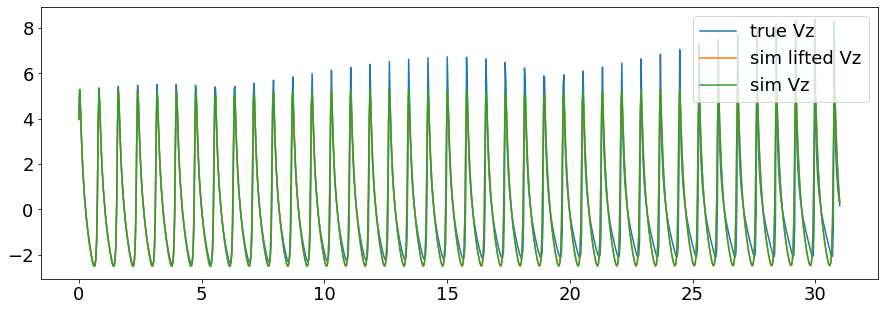

In [480]:
m_data = transf_df[transf_df.sat_id == 530]
plt.figure(figsize=(15, 5))


plt.plot(m_data['t'],m_data['Vy'], label = 'true Vz')
plt.plot(m_data['t'],0*m_data['t']+ m_data['Vy_sim'], label = 'sim lifted Vz')
plt.plot(m_data['t'],m_data['Vy_sim'], label = 'sim Vz')
# plt.xlim([28,30])

plt.legend()

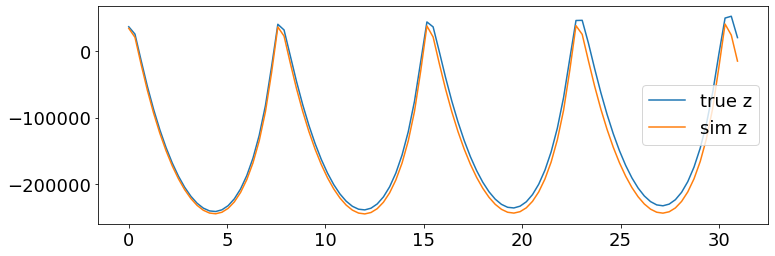

In [477]:

plt.figure(figsize=(12, 4))
plt.plot(m_data['t'],m_data['x'], label = 'true z')
plt.plot(m_data['t'],m_data['x_sim'], label = 'sim z')
# plt.xlim([0,10])
#plt.xlim([10,20])
# plt.xlim([28,30])
plt.legend()

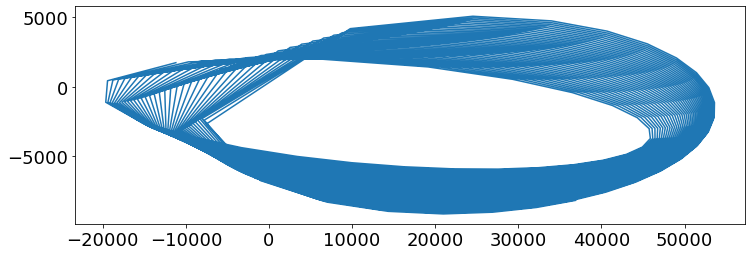

In [483]:
plt.figure(figsize=(12, 4))
plt.plot(m_data['x'],m_data['z'], label = 'true z')